In [1]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import ipywidgets as widgets
import pandas as pd
import numpy as np
import os
import networkx as nx
import altair as alt
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
%matplotlib inline

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 100000)

### Restriction to the number of years
There must be a restriction to the years, although much more data is available - it is just too much for my computer to handle it properly.

In [3]:
flights_2008 = pd.read_csv('flight_data\\2008.csv')
flights_2007 = pd.read_csv('flight_data\\2007.csv')

In [4]:
flights_all = pd.concat([flights_2008, flights_2007], ignore_index=True)

### How many flights were cancelled and why?
reason for cancellation (A = carrier, B = weather, C = NAS, D = security)

In [5]:
print("Number of cancelled flights: ",(flights_all.Cancelled == 1).sum(), "of a total of ",len(flights_all.index), "flights.")

Number of cancelled flights:  298182 of a total of  14462943 flights.


In [6]:
flights_cancel = flights_all.drop(['TailNum', 'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay', 'DepDelay', 'Origin', 'Dest', 'Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum', 'Distance', 'TaxiIn', 'TaxiOut', 'Diverted', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'], axis=1)
flights_cancel.groupby(by = 'CancellationCode', squeeze = True).count()

,Cancelled
CancellationCode,
A,121109
B,116840
C,60183
D,51


### Cluster
I want to find unusual weather events which ultimatly lead to canceled flights. For this task I will use the flights which were canceled due to weather and the origin airport and its coordinates. One of the first steps is to reduce the dimensions. I wanted to use a dimension reduce technique but it does not make any sense to apply here. The different date components cannot be standardized. The other columns do not make sense either except the distance column. We also have to add the latitude and the longitude. I get those from a different file.

In [7]:
flights_canceled_weather = flights_all.loc[flights_all['CancellationCode'] == 'B']

In [8]:
airports_all = pd.read_csv('flight_data\\airports.csv')

In [9]:
flights_canceled_weather = pd.merge(flights_canceled_weather, airports_all, left_on='Origin', right_on='iata', how='inner')

In [10]:
flights_canceled_weather = flights_canceled_weather.drop(['Origin', 'iata', 'city', 'state', 'country', 'Cancelled', 'CancellationCode', 'Distance', 'TailNum', 'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay', 'DepDelay', 'Dest', 'DayOfWeek', 'DepTime', 'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum', 'TaxiIn', 'TaxiOut', 'Diverted', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'], axis=1)

In [11]:
dimensions = flights_canceled_weather.as_matrix(columns=['Year', 'Month', 'DayofMonth', 'CRSDepTime', 'lat', 'long'])

epsilon = 0.01
X = StandardScaler().fit_transform(np.radians(dimensions))
db = DBSCAN(eps=epsilon, min_samples=8).fit(X)
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([dimensions[cluster_labels == n] for n in range(num_clusters)])
print('Number of clusters: {}'.format(num_clusters))

C:\Users\Christian\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


Number of clusters: 176


First I was thinking about ploting it in 2 dimensions, but it does not work with too many dimensions. Instead I was printing it to a .csv file. The dimensions are as follows: year, month, day, time, latitude, longitude.

In [12]:
clusters.to_csv('weather_clusters.csv')

C:\Users\Christian\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


For the rest of the analysis I ignore all flights which were cancelled. Next I check if there are columns which have huge number of missing values.

In [13]:
flights_all = flights_all.loc[flights_all['Cancelled'] == 0]

In [14]:
flights_all.isna().sum()

Year                        0
Month                       0
DayofMonth                  0
DayOfWeek                   0
DepTime                     0
CRSDepTime                  0
ArrTime                 31394
CRSArrTime                  0
UniqueCarrier               0
FlightNum                   0
TailNum                     7
ActualElapsedTime       34444
CRSElapsedTime           1325
AirTime                 34444
ArrDelay                34444
DepDelay                    0
Origin                      0
Dest                        0
Distance                    0
TaxiIn                  14215
TaxiOut                     0
Cancelled                   0
CancellationCode     14164760
Diverted                    0
CarrierDelay          5347559
WeatherDelay          5347559
NASDelay              5347559
SecurityDelay         5347559
LateAircraftDelay     5347559
dtype: int64

It can be seen here that in some rows the actual arrival time is missing. For the rest of the data analysis I delete the rows which are having missing actual arrival times.

In [15]:
flights_all.drop(flights_all.loc[flights_all['ArrDelay'].isna()].index, inplace=True)

### Density of departure and arrival delay
I only take rows into account which have a departure or arrival delay greater than 0. Something else which could be interesting  is how many flights are leaving/arriving earlier than scheduled, but I do not examine that. It can be seen that there is much arrival delay than departure delay. So even though the aircrafts start flying according to plan it is often the case that they need longer than expected.

In [16]:
flights_with_departure_delay = flights_all.loc[flights_all['DepDelay'] > 0]
flights_with_arrival_delay = flights_all.loc[flights_all['ArrDelay'] > 0]

(0, 300)

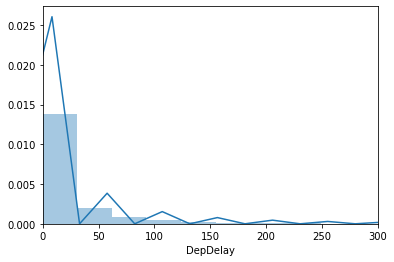

In [17]:
sns.distplot(flights_all['DepDelay'], bins=100)
plt.xlim(0,300)

(0, 300)

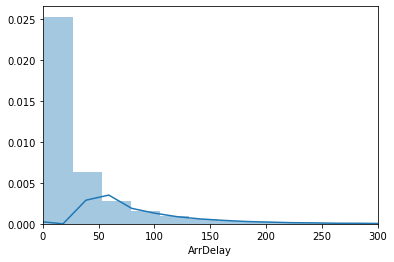

In [18]:
sns.distplot(flights_with_arrival_delay['ArrDelay'], bins=100)
plt.xlim(0, 300)

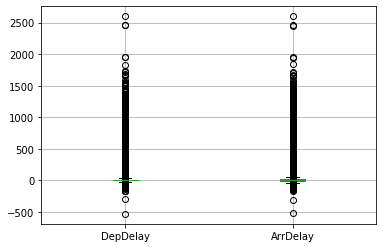

In [19]:
flights_all.boxplot(['DepDelay','ArrDelay'])

It is not really possible to read anything from this boxplot - that is why I will slice and categories the data in the next step and try to find something interesting. Next we have a closer look on the different kinds of delays. It can be clearly seen that there is a difference.

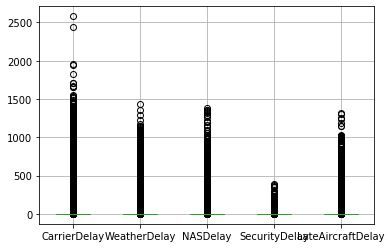

In [20]:
flights_all.boxplot(['CarrierDelay','WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'])

### Correlation between certain attributes

In [21]:
flights_corr = flights_all.drop(['Cancelled', 'Year', 'DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum', 'TailNum', 'ActualElapsedTime', 'CRSElapsedTime', 'Origin', 'Dest', 'TaxiIn', 'TaxiOut', 'CancellationCode', 'Diverted', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'], axis=1)

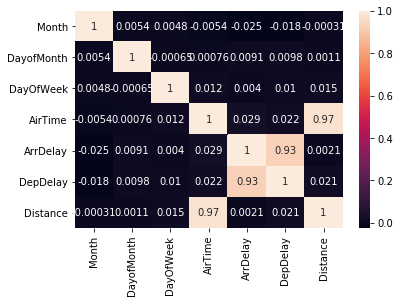

In [22]:
corr = flights_corr.corr(method='pearson')
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot = True)

No special correlation were discovered.

### Cutting flights into short, medium and long distance flights
for a more detailed analysis we assign each flight to a group.

In [23]:
flights_cat_distance = flights_all.drop(['CancellationCode', 'Cancelled', 'TailNum', 'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'Origin', 'Dest', 'Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum', 'TaxiIn', 'TaxiOut', 'Diverted', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'], axis=1)

In [24]:
labels = ["short", "medium", "long"]
flights_cat_distance['flight_distance'] = pd.cut(flights_cat_distance.Distance, [0, 700, 3000, 10000], labels=labels)

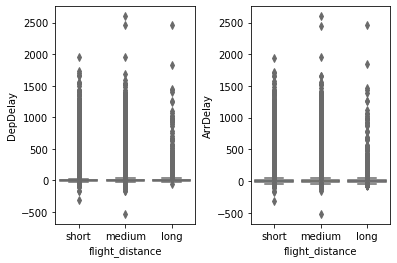

In [25]:
fig, ax = plt.subplots(1,2)
plt.subplots_adjust(wspace=0.4)
sns.boxplot(x="flight_distance", y='DepDelay', data=flights_cat_distance, palette="Set3", ax=ax[0])
sns.boxplot(x="flight_distance", y='ArrDelay', data=flights_cat_distance, palette="Set3", ax=ax[1])

In [26]:
flights_cat_distance.groupby('flight_distance').describe()

ArrDelay                                                        DepDelay                                                        Distance                                                                 
                     count      mean        std    min   25%  50%   75%     max      count       mean        std    min  25%  50%   75%     max      count         mean         std     min     25%     50%     75%     max
flight_distance                                                                                                                                                                                                            
short            8641109.0  8.987812  37.478298 -312.0  -9.0 -1.0  12.0  1942.0  8641109.0   9.975925  34.432553 -305.0 -4.0 -1.0   8.0  1956.0  8641109.0   380.231726  168.979208    11.0   238.0   368.0   528.0   700.0
medium           5467500.0  9.563963  41.042643 -519.0 -11.0 -1.0  15.0  2598.0  5467500.0  11.747960  37.389814 -534.0 -4.0  0.0  11.0  2601.0  5467500.0  1258.454388  511.332579   701.0   869.0  1057.0  1530.0  2994.0
long               21708.0  8.771006  56.285392  -71.0 -11.0 -1.0  13.0  2461.0    21708.0  11.775336  53.604155  -64.0 -4.0  0.0  10.0  2457.0    21708.0  3929.738345  483.372667  3043.0  3711.0  3904.0  4243.0  4962.0

we can see that there is at least a difference between the groups. Departure delay is longer than arrival delay on average.

### Grouping into different Carriers
We want to try to find out if specific carrier often have a delay. For better understanding we replace the shortcuts with the actual name of the carrier. For that task we will use an additional data source. The result is a list with the different carriers and a five number summary of each onefor the different attributes.

In [27]:
flights_cat_carrier = flights_all.drop(['CancellationCode', 'Cancelled', 'TailNum', 'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'Origin', 'Dest', 'Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime', 'FlightNum', 'TaxiIn', 'TaxiOut', 'Diverted', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'], axis=1)

In [28]:
carriers_all = pd.read_csv('flight_data\\carriers.csv')

In [29]:
flights_cat_carrier = pd.merge(flights_cat_carrier, carriers_all, left_on='UniqueCarrier', right_on='Code', how='inner')
flights_cat_carrier = flights_cat_carrier.drop(['Code', 'UniqueCarrier'], axis=1)

In [30]:
flights_cat_carrier.groupby('Description').describe()

ArrDelay                                                         DepDelay                                                        Distance                                                               
                                                        count       mean        std    min   25%  50%   75%     max      count       mean        std    min  25%  50%   75%     max      count         mean         std    min    25%     50%     75%     max
Description                                                                                                                                                                                                                                                  
AirTran Airways Corporation                          518582.0   8.513363  36.603234  -86.0  -9.0 -1.0  12.0  1175.0   518582.0   9.113224  33.173052  -62.0 -5.0 -2.0   8.0  1206.0   518582.0   710.803210  381.043026  215.0  432.0   620.0   861.0  2521.0
Alaska Airlines Inc.                                 305615.0   7.096523  35.732982 -312.0 -11.0 -1.0  13.0   948.0   305615.0   8.704537  33.569071 -305.0 -6.0 -1.0   9.0   947.0   305615.0   928.216668  575.345315   31.0  569.0   866.0  1050.0  2846.0
Aloha Airlines Inc.                                   53709.0  -1.595096  18.453373  -90.0  -8.0 -4.0   1.0   623.0    53709.0   0.152191  17.685938  -82.0 -6.0 -3.0   0.0   624.0    53709.0   427.479845  752.934961   76.0  100.0   163.0   216.0  2677.0
American Airlines Inc.                              1199321.0  13.546217  44.550256  -90.0  -9.0  1.0  18.0  1525.0  1199321.0  13.966436  40.914980  -64.0 -4.0 -1.0  14.0  1521.0  1199321.0  1062.267247  594.411332   21.0  647.0  1005.0  1313.0  4243.0
American Eagle Airlines Inc.                         987366.0  11.512491  42.293587  -86.0  -9.0 -1.0  16.0  1707.0   987366.0  11.939559  38.091520  -41.0 -5.0 -1.0  12.0  1710.0   987366.0   413.562923  259.537551   67.0  209.0   351.0   589.0  1371.0
Atlantic Southeast Airlines                          551484.0  13.712953  44.721442 -175.0 -10.0  0.0  19.0   969.0   551484.0  16.110620  42.243587 -165.0 -4.0  0.0  17.0  1002.0   551484.0   459.925831  230.616410   31.0  267.0   443.0   633.0  1543.0
Comair Inc.                                          415166.0  12.529856  40.446341  -81.0  -8.0  1.0  18.0  1209.0   415166.0  12.082550  35.851209  -70.0 -3.0  0.0  10.0   966.0   415166.0   484.046957  240.227971   11.0  292.0   431.0   623.0  1522.0
Continental Air Lines Inc.                           612993.0  10.609617  41.790489  -83.0 -10.0 -1.0  14.0  1017.0   612993.0  12.420390  38.305579  -33.0 -4.0  0.0  10.0  1011.0   612993.0  1149.752596  658.593385   11.0  745.0  1065.0  1416.0  4962.0
Delta Air Lines Inc.                                 912257.0   7.571720  34.621599 -132.0  -9.0 -1.0  12.0  1007.0   912257.0   7.896536  30.484689 -124.0 -4.0 -1.0   6.0  1003.0   912257.0   934.338080  690.345579   83.0  425.0   669.0  1269.0  4502.0
Expressjet Airlines Inc.                             785719.0  10.297680  42.895805 -157.0 -11.0 -2.0  13.0   939.0   785719.0  11.598831  39.269125  -71.0 -5.0 -2.0   9.0   927.0   785719.0   573.503706  304.578758   35.0  314.0   529.0   802.0  1463.0
Frontier Airlines Inc.                               192632.0   6.776470  28.432372  -67.0  -7.0  0.0  12.0   896.0   192632.0   6.659890  25.678055  -90.0 -5.0  0.0   9.0   887.0   192632.0   887.601276  327.410266  224.0  641.0   862.0  1013.0  2406.0
Hawaiian Airlines Inc.                               117147.0   0.455120  27.779705 -519.0  -7.0 -3.0   1.0  1309.0   117147.0  -0.197854  24.943187 -534.0 -6.0 -4.0  -1.0  1317.0   117147.0   595.602619  967.637304   64.0  100.0   102.0   216.0  2917.0
JetBlue Airways                                      379230.0  12.246536  49.520579  -83.0 -13.0 -2.0  17.0  1042.0   379230.0  13.619935  44.650616  -70.0 -6.0 -2.0  11.0  1048.0   379230.0  1109.385233  729.678371   21.0  426.0  1028.0  1428

### Networkx
Additionally to the cluster before I thought it would be interesting to know the best and most frequently traveled airports in the USA. To get that information I use the networkx package of python. It is also possible to draw the multigraph but it does not make any sense because there are simply way to many edges and as a consequence everything is black. Due to limited computional power I will take only a sample of data points and hope to also get approximatly the same results.

In [43]:
G = nx.MultiGraph()

In [44]:
flights_network_sample = flights_all.sample(1000000)

In [46]:
G.add_nodes_from(flights_network_sample.Origin.unique())
G.add_nodes_from(flights_network_sample.Dest.unique())

In [47]:
for index, row in flights_network_sample.iterrows():
    G.add_edge(row['Origin'], row['Dest'], color="blue")
nodes = G.nodes()
edges = G.edges()

In [48]:
pos = nx.kamada_kawai_layout(G)

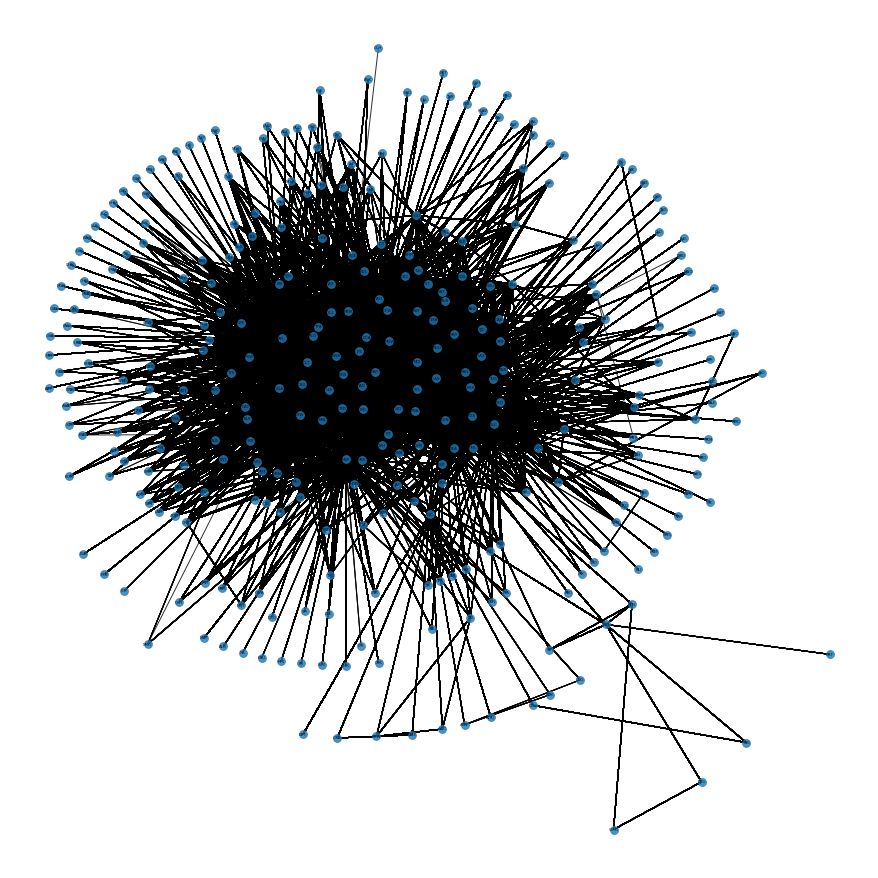

In [49]:
plt.figure(1,figsize=(12,12))
ec = nx.draw(G, pos, nodes=nodes, edges=edges, node_size=60, font_size= 4, alpha=0.8, with_labels=True)
plt.savefig("connection_network.png", dpi=1000)
plt.show()

More interesting are the top 10 best connected (also most frequent connected) airports in the USA.

In [50]:
degree = nx.degree_centrality(G)
sorted(degree.items(), key=lambda x:x[1], reverse=True)[0:10]

[('ATL', 374.39935064935065),
 ('ORD', 317.77597402597405),
 ('DFW', 257.82467532467535),
 ('DEN', 217.26623376623377),
 ('LAX', 206.10064935064938),
 ('PHX', 186.1818181818182),
 ('IAH', 174.55519480519482),
 ('LAS', 163.0422077922078),
 ('DTW', 152.67532467532467),
 ('SLC', 130.487012987013)]

### Regression with departure delay and arrival delay
The result should not be surprising - if there is a departure delay it is very likely that there is also a arrival delay (see above correlation matrix). We reduce the number of data points for this task to 1000.

In [39]:
airplans_all = pd.read_csv('flight_data\\plane-data.csv')

In [40]:
flights = pd.merge(flights_all, airplans_all, left_on='TailNum', right_on='tailnum', how='inner')

In [41]:
flights_sample = flights.sample(1000)

In [42]:
alt.Chart(flights_sample).mark_point().encode(
    x='DepDelay:Q',
    y='ArrDelay:Q',
    color='manufacturer:N',
    tooltip=['DepDelay', 'ArrDelay', 'Distance', 'manufacturer', 'model']
)

alt.Chart(...)